### This hands-on lab is to pre-process an auto dataset and perform descriptive statistical analyses. 
✔ link to download the data set: [Link](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/auto.csv)

In [427]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse, r2_score

In [2]:
# Changing the current directory
os.chdir('G:\My Drive\Career\IBM certificate\Database')

In [3]:
# reading the csv file using Pandas library
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/auto.csv"
df = pd.read_csv(url, header=None) # storing the csv file in a data frame named df

In [4]:
# add header manually to df
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]
df.columns = headers

## Rreliminary conversion

In [5]:
# thic converts mile per gallon to km per liter
df['city-mpg']=df['city-mpg']*0.425144
df['highway-mpg']=df['highway-mpg']*0.425144

## Missing values
In this section missing values are identified and replaced with appropriate values. 

In [6]:
df.head(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,8.928024,11.478888,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,8.928024,11.478888,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,8.077736,11.053744,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,10.203456,12.754320,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,7.652592,9.353168,17450


**Discussion**: Looking at the data frame header above shows there are a few cells with "?" as value. These cells should be replaced with none values using numpy.nan.

In [7]:
# replace the missing values with np.nan
df = df.replace('?',np.nan)

In [8]:
# we can now count the number of missing values
df_nan = df.isnull()
column_with_nan = []
for column in df_nan.columns.values.tolist():
    if True in df_nan[column].values:
        print(column.upper(),":" , df_nan[column].value_counts(),'\n')
        column_with_nan.append(column)
column_with_nan

NORMALIZED-LOSSES : False    164
True      41
Name: normalized-losses, dtype: int64 

NUM-OF-DOORS : False    203
True       2
Name: num-of-doors, dtype: int64 

BORE : False    201
True       4
Name: bore, dtype: int64 

STROKE : False    201
True       4
Name: stroke, dtype: int64 

HORSEPOWER : False    203
True       2
Name: horsepower, dtype: int64 

PEAK-RPM : False    203
True       2
Name: peak-rpm, dtype: int64 

PRICE : False    201
True       4
Name: price, dtype: int64 



['normalized-losses',
 'num-of-doors',
 'bore',
 'stroke',
 'horsepower',
 'peak-rpm',
 'price']

**Discussion**: The number of missing values are highest in the normalized-losses column (around 25%). These cells should be replaced by a value which represents the rest of data. The list of columns with missing values are also provided above.

#### Replacing the missing values with average value

In [9]:
# all the columns with missing values are assigned to the data frame df_with_nan
df_with_nan=pd.DataFrame()
for a in column_with_nan:
    df_with_nan[a]=df[a]
df_with_nan.head(4)

,normalized-losses,num-of-doors,bore,stroke,horsepower,peak-rpm,price
0,NaN,two,3.47,2.68,111,5000,13495
1,NaN,two,3.47,2.68,111,5000,16500
2,NaN,two,2.68,3.47,154,5000,16500
3,164,four,3.19,3.40,102,5500,13950


**Discussion**: The data frame with missing values (df_with_nan) includes columns with numeric values and object data type (only one column has object data type).

In [10]:
df_with_nan['num-of-doors'].unique()

array(['two', 'four', nan], dtype=object)

**Discussion**: There are two types of values (two and four) in the column num-of-doors. let's count the number of each value type.

In [11]:
door_value_count = df_with_nan['num-of-doors'].value_counts()
print(door_value_count)
print(f"number of missing values is equal to {205-door_value_count[0]-door_value_count[1]}")

four    114
two      89
Name: num-of-doors, dtype: int64
number of missing values is equal to 2


**Discussion**: Only 2 values are missing values. These two values will be replaced by four which has the highest frequency in the column.

In [12]:
df_with_nan['num-of-doors'].replace(np.nan,'four',inplace=True)
column_with_nan.remove('num-of-doors')
print(column_with_nan)

['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']


**Discussion**: The null values in the column num-of-doors are replaced with 'four' and this element is removed from the list column_with_nan. For the remaining elements in the list,the missing values are replaced with the average values of the column. The code is presented in the cell below. 

In [13]:
for column in column_with_nan:
    df[column] = df[column].astype('float') # change the data type to float
    normalized_not_null = df[df[column].notnull()][column] # filter only the not null values
    normalized_not_null_avg = normalized_not_null.mean() # find the average value of the column
    df[column].replace(np.nan,normalized_not_null_avg, inplace=True) # replace the missing value with the average value

**Discussion**: All the missing values in the data frame df are replaced with an appropriate value

## Normalizing dataframe in python

Normalizing the columns that have different ranges of numerical data helps the accuracy of the machine learning models.

In [14]:
# let's find the columns with non object type values
column_not_object = []
for d in df.columns:
    if df[d].dtype!=object:
        column_not_object.append(d)

In [15]:
df_max_not_object=[]
df_min_not_object=[]
for e in column_not_object:
    df_max_not_object.append(df[e].max())
    df_min_not_object.append(df[e].min())
df_max_min = pd.DataFrame({'column name':column_not_object,'min':df_min_not_object,'max':df_max_not_object})
df_max_min

,column name,min,max
0,symboling,-2.000000,3.000000
1,normalized-losses,65.000000,256.000000
2,wheel-base,86.600000,120.900000
3,length,141.100000,208.100000
4,width,60.300000,72.300000
5,height,47.800000,59.800000
6,curb-weight,1488.000000,4066.000000
7,engine-size,61.000000,326.000000
8,bore,2.540000,3.940000
9,stroke,2.070000,4.170000


**Discussion**: The results above shows that data ranges are differently distributed in different columns. For instance the curb-weight and peak-rpm columns have significantly higher data range compared to other feature variables. Let's normalize these two columns.

In [16]:
def normalize_column(col_name):
    df[col_name] = (df[col_name]-df[col_name].mean())/df[col_name].std() # (data-mean(column))/std(column)
##
normalize_column('curb-weight')
normalize_column('peak-rpm')
df[['curb-weight','peak-rpm']].head(5)

,curb-weight,peak-rpm
0,-0.014531,-0.262841
1,-0.014531,-0.262841
2,0.513625,-0.262841
3,-0.419770,0.785423
4,0.515545,0.785423


<AxesSubplot:xlabel='curb-weight', ylabel='peak-rpm'>

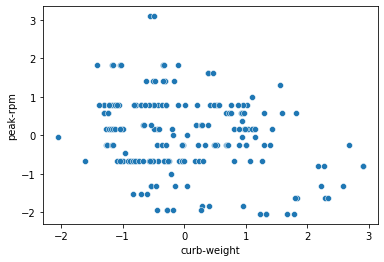

In [17]:
%%capture --no-display 
sns.scatterplot(df['curb-weight'],df['peak-rpm'])

**Discussion**: The scatter plot above shows the normalized range of columns curb-weight and peak-rpm which almost between -3 and 3.

## Binning in python
Let's group the price column to 3 categories including low, medium, and max.

In [18]:
df['price'] =  df['price'].astype('float')
price = df['price']
bins = np.linspace(min(price),max(price),4)
group_name = ('low', 'medium' , 'high')
df['price_binned']= pd.cut(df['price'] , bins, labels=group_name, include_lowest=True)

Text(0.5, 1.0, 'Price categories')

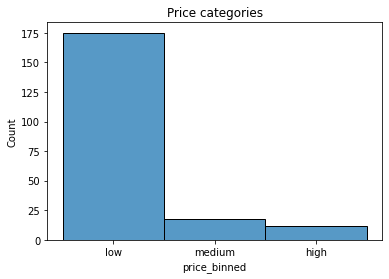

In [19]:
%%capture --no-display 
sns.histplot(df['price_binned'])
plt.title('Price categories')

**Discussion**: The plot above shows that the low priced cars (max low priced car <= 33% max car price) have higher population. The other two categories have similar number of data.The number of data in each category is presented below.

In [20]:
df_bin_count = df['price_binned'].value_counts().to_frame()
df_bin_count.rename(columns={'price_binned':'count_value'},inplace=True)
df_bin_count.index.name='price_category'
df_bin_count = df_bin_count.reset_index()
df_bin_count

,price_category,count_value
0,low,175
1,medium,18
2,high,12



## Descriptive statistic analysis:
### Continuous variables
Extracting the correlation between variables  

<AxesSubplot:>

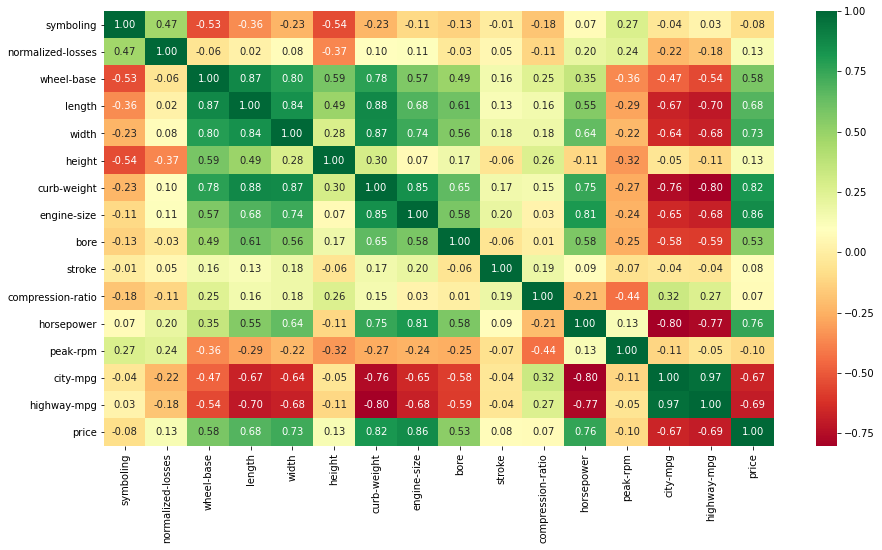

In [21]:
df_corr = df.corr() # extracting the correlation coefficient of all the continuous variables
fig, ax=plt.subplots(figsize=(15,8))
sns.heatmap(df_corr,annot=True,fmt='.2f',ax=ax,cmap='RdYlGn') # heatmap plot on corr coeffs to display what variables have siginficiant corr coeff

**Discussion**: From the heatmap plot above, it could be concluded that it is likely that the below variables are not strong predictive features for the target variable "price" ("i.e., these variables could be excluded in the machine learning model"):   
*symbolling, normalized-losses, height, stroke, compression-ration, peak-rpm*

Furthermore, the heatmap plot shows that the **engine-size** is potentially the best predictive feature for the target variable price.

Let's plot linear regression lines for engine-size (with highest corr coeff) and stroke (with lowest corr coeff).

In [22]:
def plot_regression(x,y,w,h): # plotting the linear regression and deriving the correlation coefficient for x and y 
    fig, ax=plt.subplots(figsize=(w,h))
    df_limit = df[[x,y]]
    plt.scatter(x ,y,data=df_limit)
    pr = scipy.stats.pearsonr(df[x],df[y]) # pearsonr method is employed to obtain the cor coeff and p_value
    plt.title(f'Corr coeff and p_value for {x} and {y} are equal to \n' + str(round(pr[0],3))+" and "+str(pr[1]))
    sns.regplot(x ,y,data=df_limit) # finding the linear regression between the feature variable and target variable

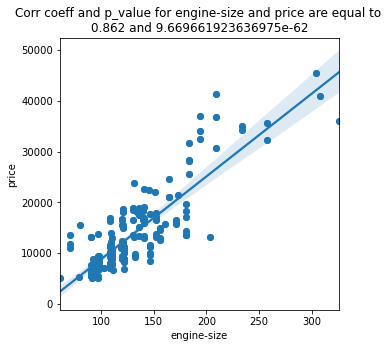

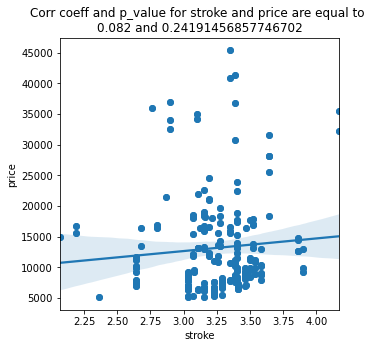

In [23]:
%%capture --no-display 
# The above magic command is used to prevent displying the warning messages
y = 'price' # target variale
w = 5 # width of the box plot
h = 5 # height of the box plot
plot_regression('engine-size',y,w,h)
plot_regression('stroke',y,w,h)

**Discussion**: The plots above shows that as expected the engine-size has a strong positive correlation with the target variable, and stroke has a very small positive correlation with price. Hence, the latter feature may not be a good predictive feature for the price variable. In order to find the strength of the dependency p_value could be extracted using pearsonr method in scipy library as shown in the title of the above plots and also presented below.

In [24]:
A='engine-size'
B='price'
corr_coeff,pearson_value =  scipy.stats.pearsonr(df[A],df[B])
print(f'correlation coefficient for {A} and {B} = {corr_coeff}')
print(f'pearson value for {A} and {B} = {pearson_value}')

correlation coefficient for engine-size and price = 0.8617522436859719
pearson value for engine-size and price = 9.669661923636975e-62


**Discussion**: Since the p value presented above is smaller than 0.001, the correlation between price and engine-size is strong and the null hypothesis could be rejected.


### Categorical variables
Association between variables

In [25]:
# let's first describe the object features
df.describe(include='object')

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
count,205,205,205,203,205,205,205,205,205,205
unique,22,2,2,2,5,3,2,7,7,8
top,toyota,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,32,185,168,114,96,120,202,148,159,94


**Discussion**: It seems to me that the feature make is a good predictive feature since it has a highest number of unique values. 

Firstly, let's check the **analysis of variance (ANOVA)** showing if there is a large difference between two or more groups within the feature variable make.

In [26]:
unique_make_list = [] # this creats a list of unique elements within the column make
for b in df['make'].unique():
    unique_make_list.append(b)

In [27]:
unique_make_comb = [] # this provides all the combinations of elements within unique_make_list with the length equal to 2
for m in itertools.combinations(unique_make_list,2):
    unique_make_comb.append(m)

In [28]:
# let's group the data frame with columns make and price based on the column make
df_make_price = df[['make','price']]
df_make_price_gr = df_make_price.groupby('make')

In [29]:
def ANOVA(x,y): # this extracts prices of unique categories (e.g., mazda) within the column "make"
    return df_make_price_gr.get_group(unique_make_comb[x][y])['price']

In [30]:
# Let's analyze the variance of every two unique make categories
ANOVA_values=[]
ANOVA_colname=[]
for c in range(len(unique_make_list)):
    ANOVA_colname.append(unique_make_comb[c])
    ANOVA_values.append(scipy.stats.f_oneway(ANOVA(c,0),ANOVA(c,1))[0:2]) 
df_ANOVA= pd.DataFrame(ANOVA_values,ANOVA_colname)
df_ANOVA.columns=['F-test-score','p-value']
df_ANOVA

,F-test-score,p-value
"(alfa-romero, audi)",0.574333,0.470275
"(alfa-romero, bmw)",3.650348,0.088378
"(alfa-romero, chevrolet)",75.508276,0.000966
"(alfa-romero, dodge)",28.917573,0.000311
"(alfa-romero, honda)",32.008671,0.000059
"(alfa-romero, isuzu)",5.033665,0.074877
"(alfa-romero, jaguar)",151.977750,0.000249
"(alfa-romero, mazda)",4.162180,0.056287
"(alfa-romero, mercedes-benz)",19.676220,0.001633
"(alfa-romero, mercury)",0.251500,0.665780


**Discussion**: The first columns shows the F-test-score displaying how much difference there is between the means of different categories of auto make. The second columns shows the p-value indicating how statistically significant the F-test-score is. If the price is strongly correlated with the feature variable make, then we expect to see high f-score and low p-value. For instance, the price of BMW and Audi cars are similar as both are from German companies and both are fairly expensive. As such, the F-score is expected to be small and p-value is expected to be quite large for a BMW and Audi. The data frame above confirms this expectation (F-score=5.69, p-value=0.033).

In [31]:
# filtering all the combincations with p-value smaller than 0.001
df_ANOVA[df_ANOVA['p-value']<0.001]

,F-test-score,p-value
"(alfa-romero, chevrolet)",75.508276,0.000966
"(alfa-romero, dodge)",28.917573,0.000311
"(alfa-romero, honda)",32.008671,0.000059
"(alfa-romero, jaguar)",151.977750,0.000249
"(alfa-romero, subaru)",31.840225,0.000080


**Discussion**: The above data frame shows the categories of car types with p-values less than 0.001. For instance Mazda and Mercedes-benz have very small p-values and high f-scores which make sense as benz cars are very expensive and Maza cars are quite inexpensive. The box plot below shows the mean price values of mazda versus benz auto make.

<AxesSubplot:title={'center':'Price distribution of mazda versus mercedes-benz cars'}, xlabel='make', ylabel='price'>

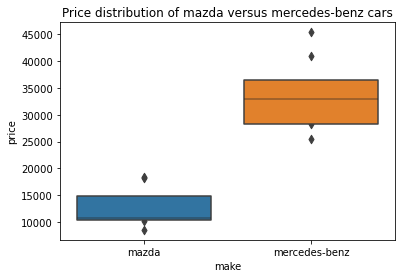

In [32]:
%%capture --no-display 
df_limit=df.iloc[60:75,:]
plt.title('Price distribution of mazda versus mercedes-benz cars')
sns.boxenplot(df_limit['make'],df_limit['price'])

**Discussion**: The box plot above shows the significantly different mean values for the price of Mazda cars versus Benz cars which cofirms the very small p-value presented above.

Now, let's check the **association** between variables to predict price using Chi square.

In [33]:
def chi_square(var1,var2):    
    df_price_make = df[[var1,var2,'price']]
    df_price_make_gr = df_price_make.groupby([var1,var2],as_index=False).mean()
    df_price_make_pivot = df_price_make_gr.pivot(index=var1,columns=var2)
    df_price_make_pivot.fillna(0,inplace=True)
    chi_square = scipy.stats.chi2_contingency(df_price_make_pivot,correction=True)
    return chi_square[0:3]

In [34]:
col_obj=[] # this list collects all the columns with object data type
for d in df.columns:
    if df[d].dtype=='object':
        col_obj.append(d)

In [35]:
col_obj_comb = [] # this list provides all the combinations of elements within col_obj list with the length equal to 2
for k in itertools.combinations(col_obj,2):
    col_obj_comb.append(k)

In [36]:
# let's analyze the association (i.e., chi-square and p-value) between differnt object type features using chi-square method
for f in range(len(col_obj_comb)):
    print(col_obj_comb[f],chi_square(col_obj_comb[f][0],col_obj_comb[f][1]))

('make', 'fuel-type') (147215.58979607973, 0.0, 21)
('make', 'aspiration') (160469.50132348516, 0.0, 21)
('make', 'num-of-doors') (94434.61754396914, 0.0, 21)
('make', 'body-style') (759904.188260034, 0.0, 84)
('make', 'drive-wheels') (444961.6142674795, 0.0, 42)
('make', 'engine-location') (221483.97554222212, 0.0, 21)
('make', 'engine-type') (1622680.2512554568, 0.0, 126)
('make', 'num-of-cylinders') (1567580.0907568969, 0.0, 126)
('make', 'fuel-system') (1490366.9111146408, 0.0, 147)
('fuel-type', 'aspiration') (988.7794997522026, 4.934145320291949e-217, 1)
('fuel-type', 'num-of-doors') (43.18101780588942, 4.9902478409148475e-11, 1)
('fuel-type', 'body-style') (24964.396519668997, 0.0, 4)
('fuel-type', 'drive-wheels') (9692.28436059937, 0.0, 2)
('fuel-type', 'engine-location') (25724.157926953172, 0.0, 1)
('fuel-type', 'engine-type') (60403.43008971685, 0.0, 6)
('fuel-type', 'num-of-cylinders') (72602.66461179515, 0.0, 6)
('fuel-type', 'fuel-system') (95660.87706743521, 0.0, 7)
('as

**Discussion**: The chi square values above indicate for all combination of object type feature variables reject the null hypothesis (i.e., p-value is smaller than 0.001).

## Predictive Analysis

Let's find the independet variables with correlation coefficients more than 0.5

In [360]:
df_cor = df.corr().loc['price'].to_frame()
cor_list = df_cor[df_cor['price']>0.5].index.to_list()
cor_list.remove('price')
print(cor_list) # list of features with correlation variable more than 0.5

['wheel-base', 'length', 'width', 'curb-weight', 'engine-size', 'bore', 'horsepower']


### Simple linear regression

In [361]:
# first let's build a linear model using only one independent variables with highest correlation coefficient.
df_cor[df_cor['price']>0.5].sort_values(by='price').tail(3)

,price
curb-weight,0.820825
engine-size,0.861752
price,1.000000


**Discussion**: As shown above engine-size has the highest correlation coefficient. Now let's built the simple linear regression model for this variable.

#### Building the model

In [407]:
lm=LinearRegression() # creating a linear regression object
y=df['price']
lm.fit(df[['engine-size']],y) # train the model
intercept=lm.intercept_
coeff=lm.coef_
print(f'price(hat) = {round(intercept,3)} + {round(coeff[0],3)} * engine-size')

price(hat) = -7457.948 + 162.836 * engine-size


#### Plotting the linear regression model using seaborn.regplot

Text(0.5, 1.0, 'Simple linear regression model')

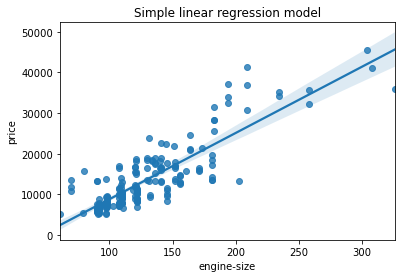

In [155]:
%%capture --no-display 
# let's plot the regression model above
sns.regplot(df[['engine-size']],y)
plt.title('Simple linear regression model')

#### Ploting the residual values - an approach to visualize data variance

Text(0.5, 1.0, 'Residual  values of the simple regression model')

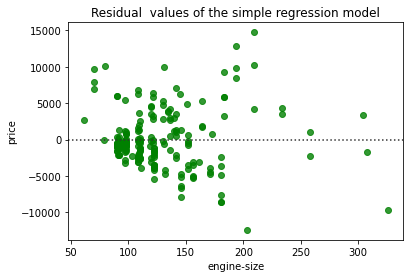

In [363]:
%%capture --no-display 
sns.residplot(df[['engine-size']],y,color='green')
plt.title('Residual  values of the simple regression model')

**Discussion**: The distribution of residual values are symmetrical with respect to 0 axis. As such, the linear regression assumption is correct and the predictive regression model could be employed to estimate the price value.

#### Plotting the distribution line for the simple regression model built above

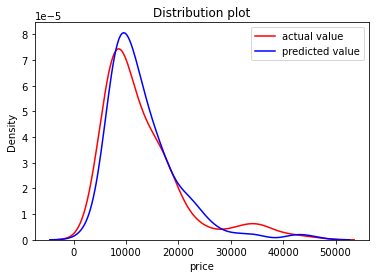

In [364]:
%%capture --no-display 
yhat_lr=lm.predict(df[['engine-size']])
ax1 = sns.distplot(y, hist=False,color='r',label="actual value")
sns.distplot(yhat_lr, hist=False,color='blue',label="predicted value",ax=ax1)
plt.title('Distribution plot')
plt.legend() 

**Discussion**: The distribution plot above shows the predictive model provides good estimation all along the price range. However it could be improved. Let's check if we can improve the accuracy using all the independent variables with the correlation coefficients more than 0.5.

### Multi-linear regression model

#### Building a model with 7 independent variables with correlation coefficients more than 0.5

In [368]:
lm.fit(df[cor_list],y) # cor_list includes all the columns names that their correlation coefficients with price is more than 0.5
intercept_multi=lm.intercept_
coeff_multi=lm.coef_
print(f"""price(hat) = {round(intercept_multi,3)}+({round(coeff_multi[0],3)}*{cor_list[0]})+({round(coeff_multi[1],3)}*{cor_list[1]})+
      ({round(coeff_multi[2],3)}*{cor_list[2]})+({round(coeff_multi[3],3)}*{cor_list[3]})+({round(coeff_multi[4],3)}*{cor_list[4]})+
      ({round(coeff_multi[5],3)}*{cor_list[5]})+({round(coeff_multi[6],3)}*{cor_list[6]})""")

price(hat) = -16821.181+(86.62*wheel-base)+(-6.686*length)+
      (179.498*width)+(1632.775*curb-weight)+(97.171*engine-size)+
      (-1491.431*bore)+(33.012*horsepower)


#### Displaying the distribution plot and comparing it with the plot from the simple regression model

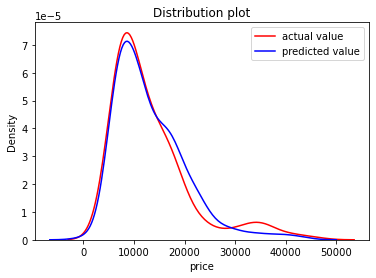

In [369]:
%%capture --no-display 
yhat_mlr = lm.predict(df[cor_list])
ax1 = sns.distplot(y, hist=False,color='r',label="actual value")
sns.distplot(yhat_mlr, hist=False,color='blue',label="predicted value",ax=ax1)
plt.title('Distribution plot')
plt.legend() 

**Discussion**: In the distribution plot above the accuracy of the predictive model enhances by increasing the number of independent variables from 1 to 7. The enhancement occurs mainly around price range of 10000. Now let's examine the accuracy of the predictive model using polynomial regression.

### Polynomial regression model - 1 dimension

#### Building the model

In [422]:
# 1 dimension polynomial regression
degree = 3
independent_var = 'engine-size' 
f = np.polyfit(df[independent_var],y,degree) # training the polynomial model and extracting the coefficients
p = np.poly1d(f) # converting the coefficients in f in to a polynomial equation
print(p) # this prints the polynomial equation

           3         2
-0.006025 x + 3.334 x - 391 x + 2.05e+04


#### Plotting the polynomial regression model

Text(0.5, 1.0, 'Polynomial regression model')

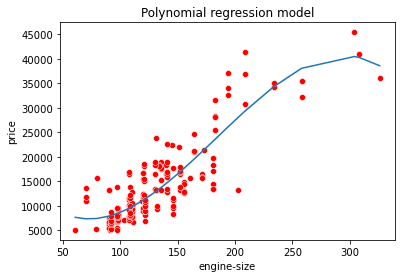

In [356]:
%%capture --no-display 
x_data = df[independent_var].to_numpy()
yhat_p = p(x_data) # applying the polynomial equation to the elements in x_data
sns.lineplot(x_data, yhat_p)
sns.scatterplot(df[independent_var], y,color='red')
plt.title('Polynomial regression model')

#### Displaying the distribution plot 

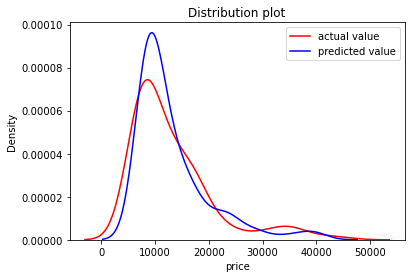

In [357]:
%%capture --no-display 
ax1 = sns.distplot(y, hist=False,color='r',label="actual value")
sns.distplot(yhat_p, hist=False,color='blue',label="predicted value",ax=ax1)
plt.title('Distribution plot')
plt.legend() 

**Discussion**: The polynomial equation with degree 3 seems to pass through more points compared to linear regression. Accordingly, the distribution plot shows an improvement in the predicted values from price range 20 to 50k. However, the accuracy of the price prediction around the price with highest density (around 10k) has decreased.

### Polynomial regression model - multi-dimension
#### Building a pipeline

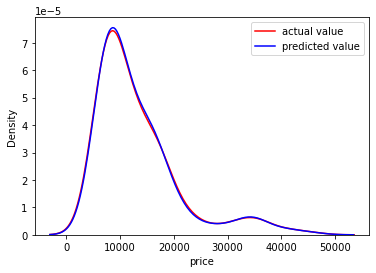

In [392]:
%%capture --no-display 
input=[('polynomial',PolynomialFeatures(degree=3,include_bias=False)),('model',LinearRegression())]
pipe=Pipeline(input)
pipe.fit(df[cor_list],y)
yhat_mp=pipe.predict(df[cor_list])
ax1 = sns.distplot(y, hist=False,color='r',label="actual value")
sns.distplot(yhat_mp, hist=False,color='blue',label="predicted value",ax=ax1)
plt.legend() 

**Discussion**: The polynomial equation with multiple feature variables provides prediction (y_hat) which is in an excellent agreement with the values of the dependent variable.

## Model evaluation
Let's evaluate the regression model developed above using **mean square error (MSE)** and **R square (also known as the coefficient of determination**.

#### Mean Square Error (MSE)

In [393]:
mse_lr = mse(yhat_lr,y) # mean squre error for simple regression model
mse_mlr = mse(yhat_mlr,y) # mean squre error for multi-linear regression model
mse_p = mse(yhat_p,y) # mean squre error for polynomial regression model
mse_mp = mse(yhat_mp,y) # mean squre error for polynomial regression model with multiple independent variables

print(f"""The mean squre error/10000 for 
smse_lr : {round(mse_lr/10000,3)}
mse_mlr : {round(mse_mlr/10000,3)}
mse_p : {round(mse_p/10000,3)}
mse_mp : {round(mse_mp/10000,3)}""")

The mean squre error/10000 for 
smse_lr : 1585.878
mse_mlr : 1361.923
mse_p : 1434.181
mse_mp : 86.531


**Discussion**: The comparison of MSE for 4 regression models indicates that using the polynomial model with multiple features leads to a significantly less error. Also, multiple linear regression performs better than simple regression model. Finally, the 1 dimension polynomial regression model provides the highest MSE.

#### R square (also known as the coefficient of determination

In [441]:
lm=LinearRegression()
lm.fit(df[['engine-size']],df['price'])
lm_score_lr= lm.score(df[['engine-size']],df['price']) # R squre for simple regression model
lm_score_lr

0.7426169294978071

In [442]:
lm.fit(df[cor_list],df['price'])
lm_score_mlr = lm.score(df[cor_list],df['price']) # R squre for simple regression model
lm_score_mlr

0.7789641029786432

In [439]:
f = np.polyfit(df['engine-size'],df['price'],3) # training the polynomial model and extracting the coefficients
p = np.poly1d(f) # converting the coefficients in f into a polynomial equation
x_data = df['engine-size'].to_numpy()
yhat_p = p(x_data) # applying the polynomial equation to the elements in x_data
r2_score(yhat_p,df['price']) # R squre for 1 dimensional polynomial regression model

0.6966215847311295

In [452]:
input=[('polynomial',PolynomialFeatures(degree=3,include_bias=False)),('model',LinearRegression())]
pipe=Pipeline(input)
pipe.fit(df[cor_list],y) # training the pipeline
pipe.score(df[cor_list],df['price']) # R squre for multi dimensional polynomial regression model

0.9859563202793192

In [451]:
# building input including the scaling
input=[('scale',StandardScaler()),('polynomial',PolynomialFeatures(degree=3,include_bias=False)),('model',LinearRegression())]
pipe=Pipeline(input)
pipe.fit(df[cor_list],y) # training the pipeline
pipe.score(df[cor_list],df['price']) # R squre for multi dimensional polynomial regression model

0.9859563202852429

**Discussion**: The comparison of R square for 4 regression models indicates similar findings to those presented above for MSE. Also, for multi-dimensional polynomial equation when scaling is employed, the R square improves but it is negligible.